# Ordinal Analysis of Wine Dataset


--- Checking Imbalance ---

Quality distribution:
quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64


<ipython-input-7-8ab428c7c028>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df, palette='coolwarm')


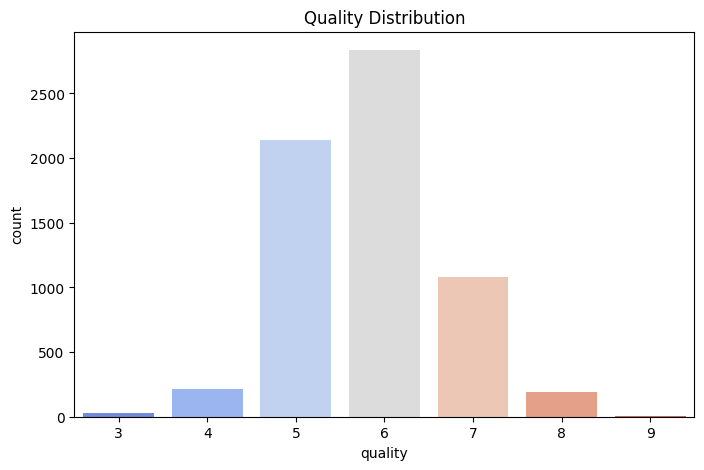


--- Checking Feature Independence ---


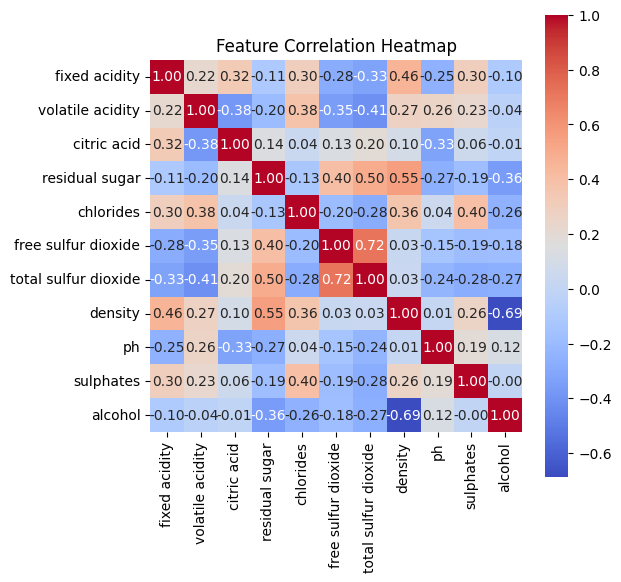


Highly correlated feature pairs (|correlation| > 0.8):

--- Variance Inflation Factor (VIF) ---
                 feature         VIF
7                density  936.984064
8                     ph  589.005172
10               alcohol  107.135452
0          fixed acidity   58.897405
9              sulphates   18.491253
6   total sulfur dioxide   14.732237
2            citric acid    9.340251
1       volatile acidity    8.943681
5    free sulfur dioxide    8.452180
4              chlorides    5.575434
3         residual sugar    3.576148


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Read the Excel file
file_path = '/content/combined_wine_dataset.xlsx'

df_raw = pd.read_excel(file_path, header=None)

# Step 2: Extract the header and data
column_string = df_raw.iloc[0, 0]
columns = [col.strip().strip('"') for col in column_string.split(';')]

# Step 3: Extract the data
data = df_raw.iloc[1:, 0].str.split(';', expand=True)
data.columns = columns

# Step 4: Convert numbers
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Step 5: Clean column names
data.columns = data.columns.str.strip().str.lower()

# Now, df is ready
df = data.copy()

# 1. Check imbalance in 'quality'
print("\n--- Checking Imbalance ---")
print("\nQuality distribution:")
print(df['quality'].value_counts())

# Plot quality distribution
plt.figure(figsize=(8,5))
sns.countplot(x='quality', data=df, palette='coolwarm')
plt.title('Quality Distribution')
plt.show()

# 2. Check feature independence (correlation)
print("\n--- Checking Feature Independence ---")

# Remove 'quality' to check only feature correlations
# feature_cols = [col for col in df.columns]          #all cols
feature_cols = [col for col in df.columns if col != 'quality']   #cols w/o quality
feature_df = df[feature_cols]

# Correlation matrix
corr_matrix = feature_df.corr()

# Plot heatmap
plt.figure(figsize=(6,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

# Optional: Find highly correlated features
threshold = 0.8
high_corr = []
seen = set()

for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 != col2 and (col2, col1) not in seen:
            if abs(corr_matrix.loc[col1, col2]) > threshold:
                high_corr.append((col1, col2, corr_matrix.loc[col1, col2]))
                seen.add((col1, col2))

print("\nHighly correlated feature pairs (|correlation| > 0.8):")
for col1, col2, corr_val in high_corr:
    print(f"{col1} and {col2}: Correlation = {corr_val:.2f}")

# 3. VIF calculation
print("\n--- Variance Inflation Factor (VIF) ---")
vif_data = pd.DataFrame()
vif_data['feature'] = feature_df.columns
vif_data['VIF'] = [variance_inflation_factor(feature_df.values, i) for i in range(feature_df.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))


In [ ]:
# Re-execute required imports after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report
)
from imblearn.over_sampling import SMOTE
from collections import Counter


In [ ]:
# Drop class 9  --> has only 5 samples, might be statistically insignificant.
#Also, it's less than 5+1 in numbers, meaning we can't use SMOTE with default neighbors=5.
#Lesser number of neighbors --> less generalization in oversampling, more overfitting.


'''
--- Checking Imbalance ---

Quality distribution:
quality
3      30    --> oversampled
4     216    --> oversampled
5    2138    --> as it is
6    2836    --> as it is
7    1079    --> oversampled
8     193    --> oversampled
9       5    --> discarded
'''
df = df[df['quality'] != 9]  # Drop class 9 (only 5 samples)

# Split features and labels
X = df.drop(columns='quality').values
y = df['quality'].values

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42                     #0.3
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE with specific sampling strategy
smote = SMOTE(
    sampling_strategy={3: 600, 4: 600, 8: 600, 7: 1000},
    random_state=42
)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define models with class_weight='balanced'
models = {
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial', solver='lbfgs', max_iter=1000,
        random_state=42, class_weight='balanced'
    ),
    'SVM (Linear)': SVC(kernel='linear', decision_function_shape='ovr', class_weight='balanced'),
    'SVM (RBF)': SVC(kernel='rbf', decision_function_shape='ovr', class_weight='balanced'),
    'SVM (Polynomial)': SVC(kernel='poly', degree=3, decision_function_shape='ovr', class_weight='balanced'),
    'SVM (Sigmoid)': SVC(kernel='sigmoid', decision_function_shape='ovr', class_weight='balanced')
}

# Train and evaluate
metrics = {
    'Model': [],
    'Set': [],
    'Accuracy': [],
    'Macro Precision': [],
    'Macro Recall': [],
    'Macro F1': [],
    'Micro Precision': [],
    'Micro Recall': [],
    'Micro F1': [],
    'Weighted Precision': [],
    'Weighted Recall': [],
    'Weighted F1': [],
    'Geometric Mean (Macro)': []
}

for model_name, model in models.items():
    # ORIGINAL DATA
    model.fit(X_train_scaled, y_train)
    y_pred_orig = model.predict(X_test_scaled)

    # SMOTE DATA
    model.fit(X_resampled, y_resampled)
    y_pred_smote = model.predict(X_test_scaled)

    for label, y_pred, source in [('Original', y_pred_orig, 'Original'), ('SMOTE', y_pred_smote, 'SMOTE')]:
        metrics['Model'].append(model_name)
        metrics['Set'].append(source)
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        macro_p = precision_score(y_test, y_pred, average='macro')
        macro_r = recall_score(y_test, y_pred, average='macro')
        macro_f = f1_score(y_test, y_pred, average='macro')
        micro_p = precision_score(y_test, y_pred, average='micro')
        micro_r = recall_score(y_test, y_pred, average='micro')
        micro_f = f1_score(y_test, y_pred, average='micro')
        weighted_p = precision_score(y_test, y_pred, average='weighted')
        weighted_r = recall_score(y_test, y_pred, average='weighted')
        weighted_f = f1_score(y_test, y_pred, average='weighted')
        gmean_macro = np.cbrt(macro_p * macro_r * macro_f)

        metrics['Macro Precision'].append(macro_p)
        metrics['Macro Recall'].append(macro_r)
        metrics['Macro F1'].append(macro_f)
        metrics['Micro Precision'].append(micro_p)
        metrics['Micro Recall'].append(micro_r)
        metrics['Micro F1'].append(micro_f)
        metrics['Weighted Precision'].append(weighted_p)
        metrics['Weighted Recall'].append(weighted_r)
        metrics['Weighted F1'].append(weighted_f)
        metrics['Geometric Mean (Macro)'].append(gmean_macro)

metrics_df = pd.DataFrame(metrics)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
metrics_df

,Model,Set,Accuracy,Macro Precision,Macro Recall,Macro F1,Micro Precision,Micro Recall,Micro F1,Weighted Precision,Weighted Recall,Weighted F1,Geometric Mean (Macro)
0,Logistic Regression,Original,0.294072,0.269566,0.379462,0.228600,0.294072,0.294072,0.294072,0.486789,0.294072,0.344738,0.285958
1,Logistic Regression,SMOTE,0.307159,0.273049,0.381370,0.234738,0.307159,0.307159,0.307159,0.493327,0.307159,0.358653,0.290218
2,SVM (Linear),Original,0.310239,0.271513,0.374865,0.236761,0.310239,0.310239,0.310239,0.492060,0.310239,0.351897,0.288841
3,SVM (Linear),SMOTE,0.301001,0.270822,0.351231,0.227171,0.301001,0.301001,0.301001,0.500994,0.301001,0.349664,0.278533
4,SVM (RBF),Original,0.411855,0.311177,0.427254,0.306282,0.411855,0.411855,0.411855,0.533790,0.411855,0.438750,0.344037
5,SVM (RBF),SMOTE,0.403387,0.302180,0.427082,0.298935,0.403387,0.403387,0.403387,0.518505,0.403387,0.431953,0.337897
6,SVM (Polynomial),Original,0.477290,0.331160,0.430539,0.345700,0.477290,0.477290,0.477290,0.533025,0.477290,0.496380,0.366648
7,SVM (Polynomial),SMOTE,0.436490,0.304792,0.393898,0.304477,0.436490,0.436490,0.436490,0.518138,0.436490,0.464710,0.331880
8,SVM (Sigmoid),Original,0.144727,0.238127,0.149899,0.128947,0.144727,0.144727,0.144727,0.470451,0.144727,0.193586,0.166344
9,SVM (Sigmoid),SMOTE,0.178599,0.235988,0.219714,0.151283,0.178599,0.178599,0.178599,0.458320,0.178599,0.227158,0.198692


In [ ]:
def plot_metric_comparison(metrics_df, metric='Accuracy', figsize=(10, 6), ylim=(0, 1)):
    """
    Plots a bar chart comparing a given metric between Original and SMOTE data across models.

    Parameters:
        metrics_df (pd.DataFrame): The dataframe containing model performance metrics.
        metric (str): The metric to plot (e.g., 'Accuracy', 'Macro F1', 'Weighted F1', etc.)
        figsize (tuple): Size of the figure.
        ylim (tuple): Y-axis limits.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Pivot the data to have 'Model' as index and 'Set' (Original/SMOTE) as columns
    df_plot = metrics_df.pivot(index='Model', columns='Set', values=metric)

    # Order models if you want consistent order
    model_order = ['Logistic Regression', 'SVM (Linear)', 'SVM (RBF)', 'SVM (Polynomial)', 'SVM (Sigmoid)']
    df_plot = df_plot.reindex(model_order)

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    df_plot.plot(kind='bar', ax=ax)

    # Auto-customize
    ax.set_title(f'{metric} Comparison: Original vs SMOTE Oversampling')
    ax.set_ylabel(metric)
    ax.set_xlabel('Model')
    ax.set_ylim(*ylim)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


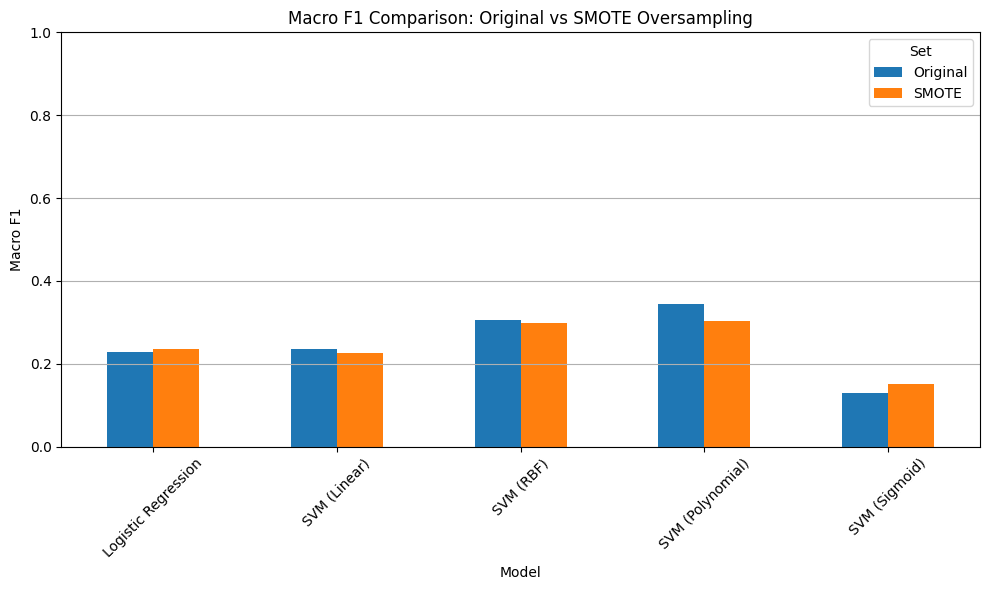

In [ ]:
# plot_metric_comparison(metrics_df, metric='Accuracy')
plot_metric_comparison(metrics_df, metric='Macro F1')
# plot_metric_comparison(metrics_df, metric='Geometric Mean (Macro)', ylim=(0, 0.6))


In [ ]:
pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=9f22c706ff82c8e3f31761701d54e268649d903f61dc9c4202e519f69e8e21fe
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, f1_score, precision_score,
    recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

def evaluate_model(model, X_train, y_train, X_test, y_test,
                   model_name='Model',
                   use_smote=False, smote_strategy=None,
                   grid_search=False, param_grid=None, search_type='grid',
                   labels=None, n_jobs=1,
                   feature_selection=False, features_selected=None):
    """
    Trains and evaluates a classification model with optional SMOTE, feature selection, and hyperparameter search.

    Parameters:
        model: sklearn or mord classifier
        X_train, y_train, X_test, y_test: datasets (DataFrame or np.array)
        model_name: Name to display in plots
        use_smote: Whether to apply SMOTE
        smote_strategy: Dictionary for sampling_strategy in SMOTE
        grid_search: Whether to perform hyperparameter tuning
        param_grid: Grid of parameters to search
        search_type: 'grid' or 'random'
        labels: Class labels for consistency in plots
        n_jobs: Number of parallel jobs
        feature_selection: Whether to apply feature selection
        features_selected: List of column names or indices
    """
    # 🔧 Apply feature selection if specified
    if feature_selection and features_selected is not None:
        if isinstance(X_train, pd.DataFrame):
            # If DataFrame, use column names directly
            X_train = X_train[features_selected].values
            X_test = X_test[features_selected].values
        else:
            # If NumPy array, use indices
            X_train = X_train[:, features_selected]
            X_test = X_test[:, features_selected]

    # 🧪 Apply SMOTE if requested
    if use_smote:
        if smote_strategy:
            sm = SMOTE(sampling_strategy=smote_strategy, random_state=42)
        else:
            sm = SMOTE(random_state=42, k_neighbors=5)
        X_train, y_train = sm.fit_resample(X_train, y_train)


    # 🔍 Grid/Randomized Search
    if grid_search and param_grid:
        if search_type == 'grid':
            searcher = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=n_jobs)
        else:
            searcher = RandomizedSearchCV(model, param_distributions=param_grid,
                                          n_iter=10, cv=5, scoring='f1_weighted', n_jobs=n_jobs, random_state=42)
        searcher.fit(X_train, y_train)
        model = searcher.best_estimator_
        print(f"🔍 Best Params ({search_type.title()}Search):", searcher.best_params_)

    # 🧠 Fit and Predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 📋 Report
    print(f"\n📋 Classification Report - {model_name}:\n")
    print(classification_report(y_test, y_pred, labels=labels, zero_division=0))

    if labels is None:
        labels = np.unique(np.concatenate([y_test, y_pred]))

    # 📊 Metrics
    precision = precision_score(y_test, y_pred, average=None, labels=labels, zero_division=0)
    recall = recall_score(y_test, y_pred, average=None, labels=labels, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=None, labels=labels, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)

    metrics_df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }, index=labels)

    # 📈 Plot metrics
    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title(f"{model_name} - Class-wise Precision, Recall, and F1-Score")
    plt.xlabel("Wine Quality Class")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(True, axis='y')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 🔵 Accuracy plot
    plt.figure(figsize=(4, 5))
    sns.barplot(x=[model_name], y=[accuracy])
    plt.title(f"{model_name} - Accuracy Score")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # 🧮 Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return metrics_df, accuracy, cm


In [ ]:
# df.columns
import mord as m


📋 Classification Report - Ordinal Logistic Regression (Selected Features):

              precision    recall  f1-score   support

           3       0.05      0.17      0.08         6
           4       0.07      0.33      0.12        43
           5       0.69      0.14      0.23       428
           6       0.50      0.71      0.59       567
           7       0.42      0.34      0.38       216
           8       0.22      0.05      0.08        39

    accuracy                           0.43      1299
   macro avg       0.33      0.29      0.25      1299
weighted avg       0.52      0.43      0.40      1299



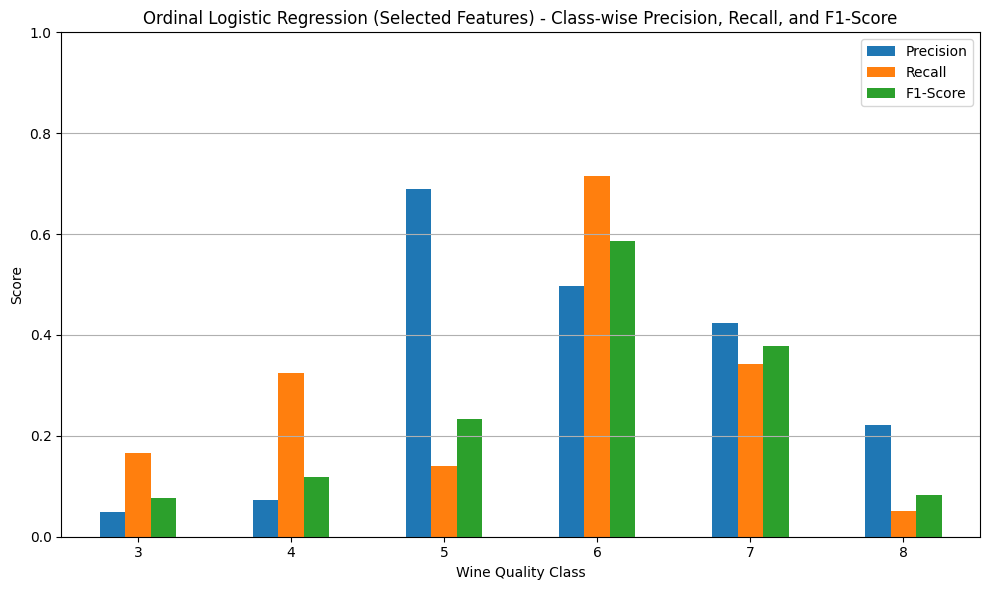

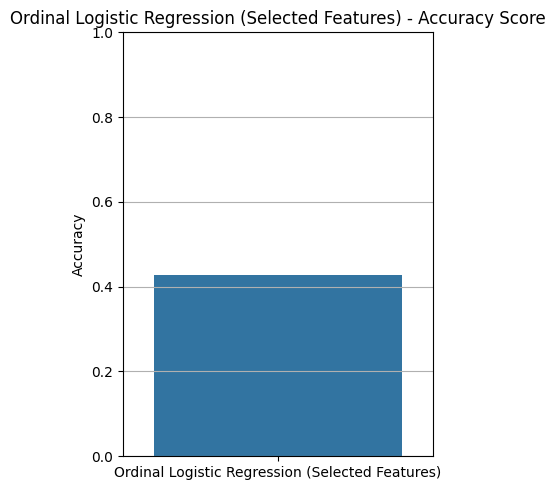

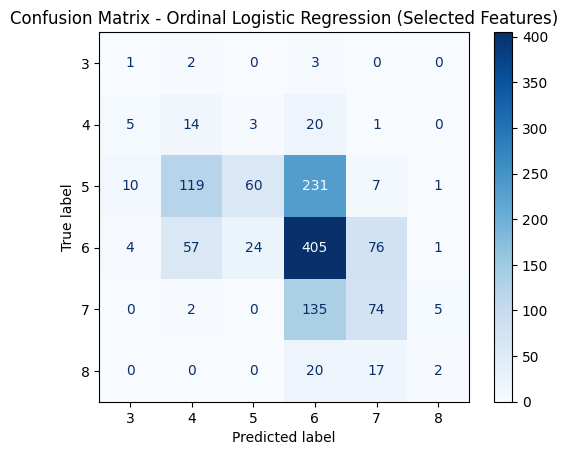

(   Precision    Recall  F1-Score
 3   0.050000  0.166667  0.076923
 4   0.072165  0.325581  0.118143
 5   0.689655  0.140187  0.233010
 6   0.497543  0.714286  0.586531
 7   0.422857  0.342593  0.378517
 8   0.222222  0.051282  0.083333,
 0.42802155504234024,
 array([[  1,   2,   0,   3,   0,   0],
        [  5,  14,   3,  20,   1,   0],
        [ 10, 119,  60, 231,   7,   1],
        [  4,  57,  24, 405,  76,   1],
        [  0,   2,   0, 135,  74,   5],
        [  0,   0,   0,  20,  17,   2]]))

In [ ]:

# import numpy as np

# Define the selected feature column names
feature_selected = [10,7,1,6,9,4,5,3,8] #,0,2]

# Instantiate ordinal logistic regression model
ord_model = m.LogisticIT()

# Call the evaluate_model function
evaluate_model(
    model=ord_model,
    X_train=X_train_scaled,     # must be a DataFrame with column names
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name='Ordinal Logistic Regression (Selected Features)',
    feature_selection=True,
    features_selected=feature_selected,
    use_smote=True,
    # smote_strategy={3: 2000, 4: 2000, 5: 2500, 6:3000, 8: 2000, 7: 2000},
    smote_strategy={3: 700, 4: 1500, 8: 600, 7: 1500},
    labels=np.arange(3, 9)
)


In [ ]:
# # ---- Custom Ordinal SVM Class ---- #
# from sklearn.base import BaseEstimator, ClassifierMixin

# class CustomOrdinalSVM(BaseEstimator, ClassifierMixin):
#     def __init__(self, kernel="rbf", C=1.0):
#         self.kernel = kernel
#         self.C = C
#         self.models = []
#         self.classes_ = []

#     def fit(self, X, y):
#         self.classes_ = np.sort(np.unique(y))
#         self.models = []
#         for threshold in self.classes_[:-1]:
#             binary_y = (y > threshold).astype(int)
#             model = SVC(kernel=self.kernel, C=self.C, probability=True)
#             model.fit(X, binary_y)
#             self.models.append(model)
#         return self

#     def predict(self, X):
#         probs = np.zeros((X.shape[0], len(self.models)))
#         for i, model in enumerate(self.models):
#             probs[:, i] = model.predict_proba(X)[:, 1]
#         return np.sum(probs > 0.5, axis=1) + self.classes_[0]

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
import numpy as np

class FlexibleOrdinalSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel="rbf", C=1.0, decision_threshold=0.5):
        self.kernel = kernel
        self.C = C
        self.decision_threshold = decision_threshold
        self.models = []
        self.classes_ = []

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        self.models = []
        for threshold in self.classes_[:-1]:
            binary_y = (y > threshold).astype(int)
            model = SVC(kernel=self.kernel, C=self.C, probability=True)
            model.fit(X, binary_y)
            self.models.append(model)
        return self

    def predict(self, X):
        probs = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            probs[:, i] = model.predict_proba(X)[:, 1]
        passed_thresholds = (probs > self.decision_threshold).sum(axis=1)
        return passed_thresholds + self.classes_[0]



📋 Classification Report - Ordinal SVM with Flexible Threshold:

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.09      0.21      0.13        43
           5       0.48      0.67      0.56       428
           6       0.50      0.24      0.33       567
           7       0.36      0.54      0.43       216
           8       0.00      0.00      0.00        39

    accuracy                           0.42      1299
   macro avg       0.24      0.28      0.24      1299
weighted avg       0.44      0.42      0.40      1299



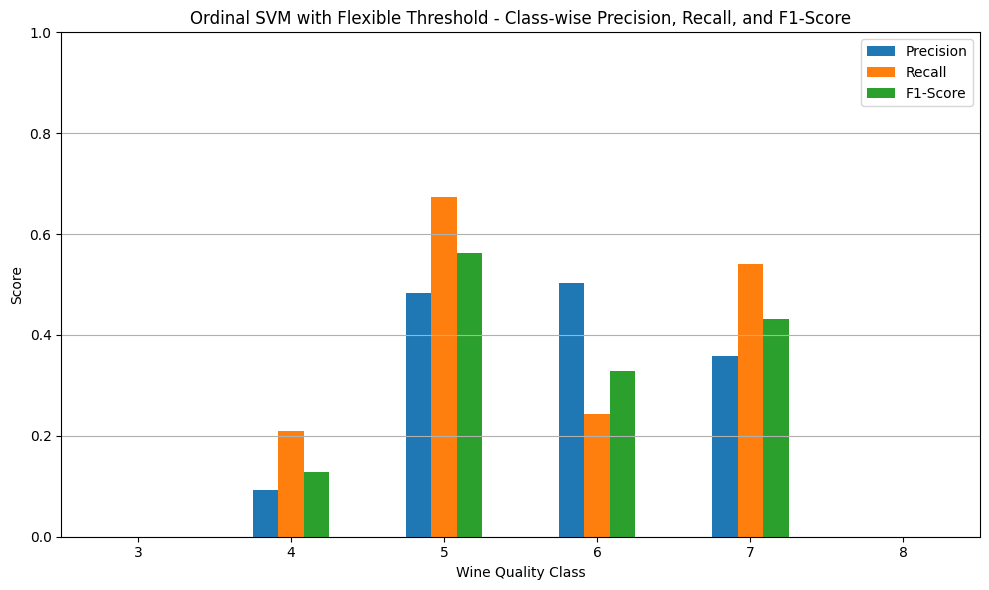

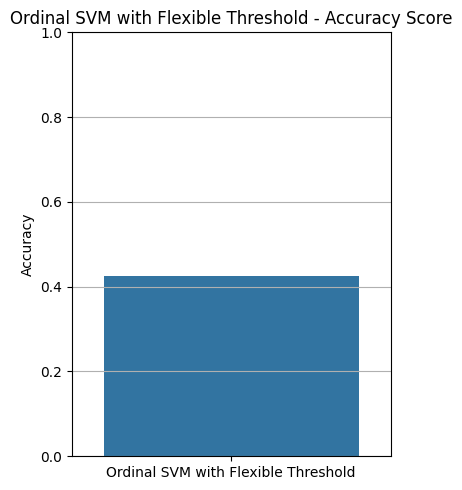

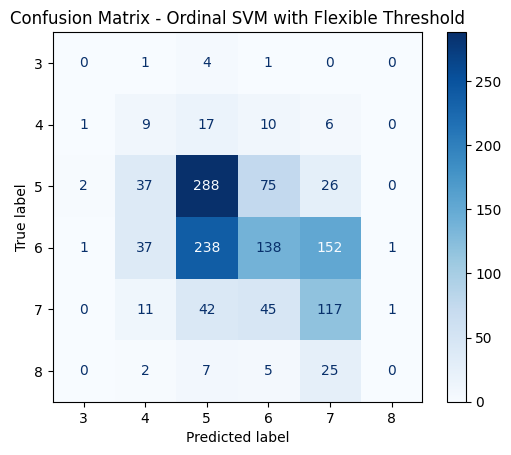

(   Precision    Recall  F1-Score
 3   0.000000  0.000000  0.000000
 4   0.092784  0.209302  0.128571
 5   0.483221  0.672897  0.562500
 6   0.503650  0.243386  0.328181
 7   0.358896  0.541667  0.431734
 8   0.000000  0.000000  0.000000,
 0.42494226327944573,
 array([[  0,   1,   4,   1,   0,   0],
        [  1,   9,  17,  10,   6,   0],
        [  2,  37, 288,  75,  26,   0],
        [  1,  37, 238, 138, 152,   1],
        [  0,  11,  42,  45, 117,   1],
        [  0,   2,   7,   5,  25,   0]]))

In [ ]:
# # Select feature indices as in your previous example
# feature_selected = [10, 7, 1] # 6   #, 9, 4, 5, 3]  # modify as needed

# # Instantiate your custom ordinal SVM model
# custom_ord_svm = CustomOrdinalSVM(kernel="rbf", C=10)

# # Call the evaluate_model function
# evaluate_model(
#     model=custom_ord_svm,
#     X_train=X_train,    # should be a NumPy array or DataFrame
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test,
#     model_name='Custom Ordinal SVM',
#     feature_selection=True,
#     features_selected=feature_selected,
#     use_smote=True,
#     smote_strategy={3: 1500, 4: 1500, 7: 1500, 8: 1500},
#     labels=np.arange(3, 9)
# )

# Instantiate with different threshold and C
model = FlexibleOrdinalSVM(kernel='rbf', C=10, decision_threshold=0.5)

evaluate_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Ordinal SVM with Flexible Threshold",
    feature_selection=True,
    features_selected=[10, 7, 1, 6, 9, 4], #, 5, 3],
    use_smote=True,
    smote_strategy='auto',
    labels=np.arange(3, 9)
)



In [ ]:
# feature_ranks = [10, 7, 1, 6, 9, 4, 5, 3]

# for k in range(1, len(feature_ranks) + 1):
#     evaluate_model(
#         model=CustomOrdinalSVM(kernel="rbf", C=1),
#         X_train=X_train,
#         y_train=y_train,
#         X_test=X_test,
#         y_test=y_test,
#         model_name=f'Ordinal SVM (top {k} features)',
#         feature_selection=True,
#         features_selected=feature_ranks[:k],
#         use_smote=True,
#         smote_strategy={3: 1500, 4: 1500, 7: 1500, 8: 1500},
#         labels=np.arange(3, 9)
#     )


📋 Classification Report - Ordinal Logistic Regression:

              precision    recall  f1-score   support

           3       0.01      0.50      0.02         6
           4       0.03      0.05      0.04        43
           5       0.46      0.20      0.28       428
           6       0.46      0.30      0.36       567
           7       0.25      0.19      0.22       216
           8       0.08      0.59      0.15        39

    accuracy                           0.25      1299
   macro avg       0.22      0.30      0.18      1299
weighted avg       0.40      0.25      0.29      1299



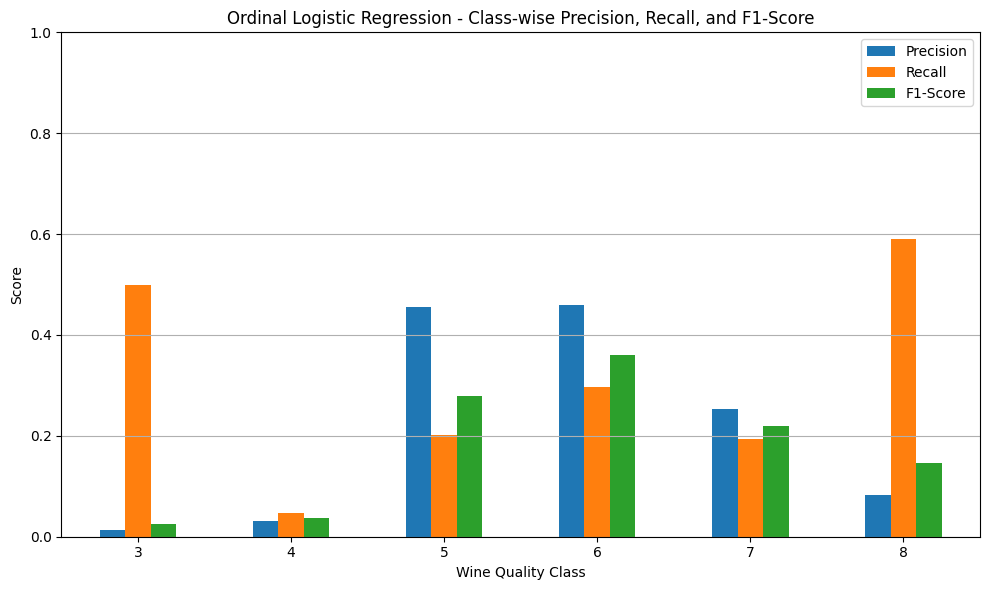

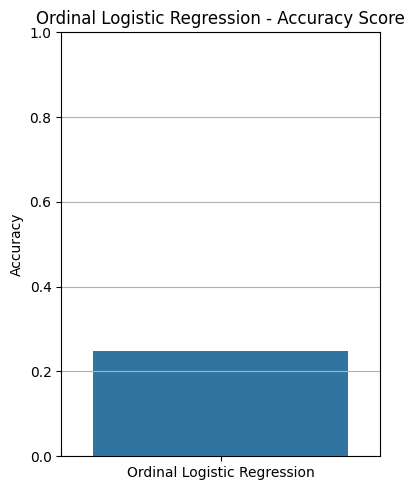

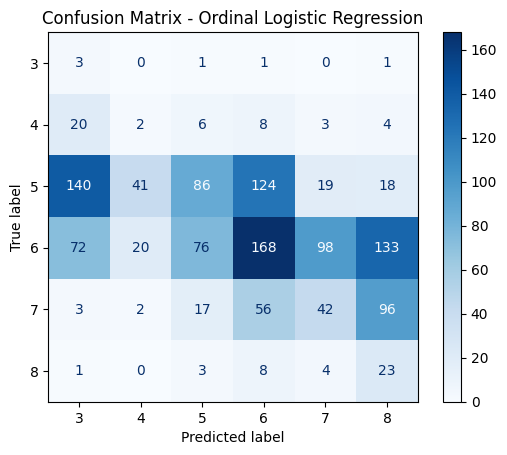

(   Precision    Recall  F1-Score
 3   0.012552  0.500000  0.024490
 4   0.030769  0.046512  0.037037
 5   0.455026  0.200935  0.278768
 6   0.460274  0.296296  0.360515
 7   0.253012  0.194444  0.219895
 8   0.083636  0.589744  0.146497,
 0.24942263279445728,
 array([[  3,   0,   1,   1,   0,   1],
        [ 20,   2,   6,   8,   3,   4],
        [140,  41,  86, 124,  19,  18],
        [ 72,  20,  76, 168,  98, 133],
        [  3,   2,  17,  56,  42,  96],
        [  1,   0,   3,   8,   4,  23]]))

In [ ]:
# import mord as m
ord_model = m.LogisticIT()
evaluate_model(ord_model, X_train_scaled, y_train, X_test_scaled, y_test,
               model_name='Ordinal Logistic Regression',
               use_smote=True,
              #  smote_strategy={3: 1500, 4: 1500, 7: 1500, 8: 1500},
              #  smote_strategy = 'auto',
              #  feature_selection = True,
              #  features_selected = [10, 7, 1],
               labels=np.arange(3, 9))

In [ ]:
# from sklearn.svm import SVC
# svm_model = SVC(kernel='rbf',  C=0.5, gamma=2)     #class_weight='balanced')  #maybe use girdsearch best params here.
# evaluate_model(svm_model, X_train_scaled, y_train, X_test_scaled, y_test,
#                model_name='SVM (RBF)',
#                use_smote=True,
#               #  smote_strategy=None,
#                smote_strategy={3: 1500, 4: 1500, 7: 1500, 8: 1500},
#                labels=np.arange(3, 9))


📋 Classification Report - SVM (RBF):

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.39      0.21      0.27        43
           5       0.71      0.66      0.68       428
           6       0.64      0.73      0.68       567
           7       0.65      0.58      0.61       216
           8       0.47      0.38      0.42        39

    accuracy                           0.65      1299
   macro avg       0.48      0.43      0.45      1299
weighted avg       0.65      0.65      0.65      1299



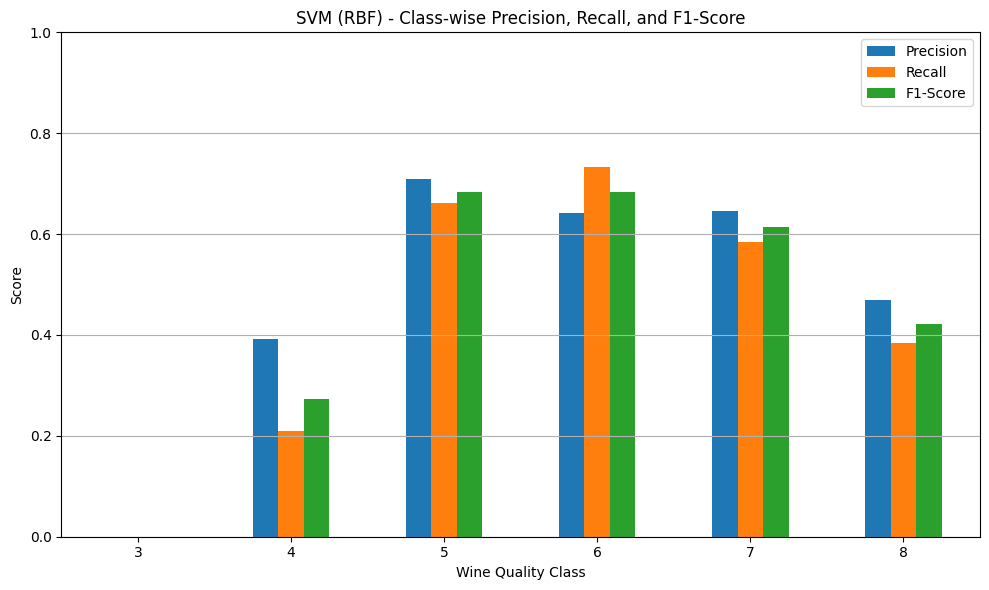

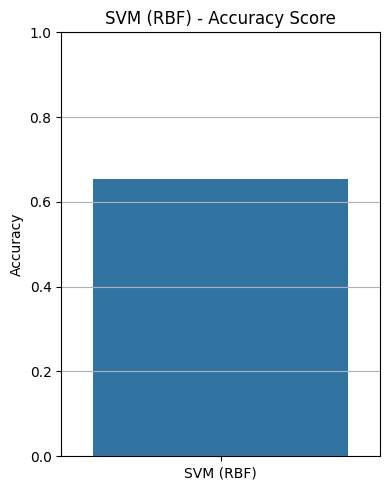

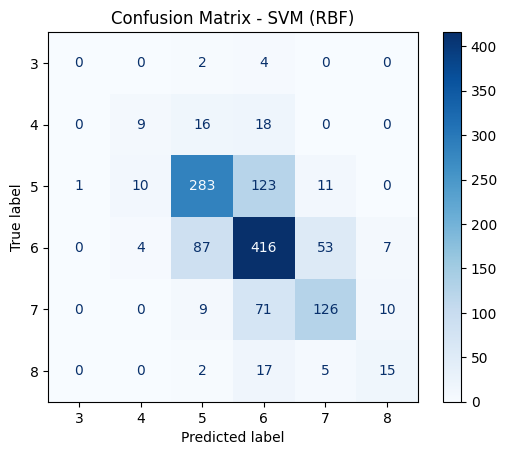

(   Precision    Recall  F1-Score
 3   0.000000  0.000000  0.000000
 4   0.391304  0.209302  0.272727
 5   0.709273  0.661215  0.684401
 6   0.640986  0.733686  0.684211
 7   0.646154  0.583333  0.613139
 8   0.468750  0.384615  0.422535,
 0.6535796766743649,
 array([[  0,   0,   2,   4,   0,   0],
        [  0,   9,  16,  18,   0,   0],
        [  1,  10, 283, 123,  11,   0],
        [  0,   4,  87, 416,  53,   7],
        [  0,   0,   9,  71, 126,  10],
        [  0,   0,   2,  17,   5,  15]]))

In [ ]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf',  C=10, gamma=1, class_weight = 'balanced')     #class_weight='balanced')  #maybe use girdsearch best params here.
evaluate_model(svm_model, X_train_scaled, y_train, X_test_scaled, y_test,
               model_name='SVM (RBF)',
               use_smote=True,
              #  smote_strategy=None,
               smote_strategy={3: 1500, 4: 1500, 7: 1500, 8: 1500},
               labels=np.arange(3, 9))

In [ ]:
# from sklearn.svm import SVC
# custom_weights = {3: 6, 4: 4, 5: 1, 6: 1, 7: 2, 8: 4}
# svm_model = SVC(kernel='rbf', class_weight=custom_weights, C=0.5, gamma=1.8)      #2


# evaluate_model(svm_model, X_train_scaled, y_train, X_test_scaled, y_test,
#                model_name='SVM (RBF)',
#                use_smote=False,
#                smote_strategy=None,
#               #  smote_strategy={3: 100, 4: 200, 8: 600, 7: 900},
#                labels=np.arange(3, 9))

🔍 Best Params (GridSearch): {'C': 10, 'gamma': 1}

📋 Classification Report - SVM (RBF):

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.39      0.21      0.27        43
           5       0.71      0.65      0.68       428
           6       0.64      0.73      0.68       567
           7       0.64      0.58      0.61       216
           8       0.47      0.38      0.42        39

    accuracy                           0.65      1299
   macro avg       0.47      0.43      0.44      1299
weighted avg       0.64      0.65      0.64      1299



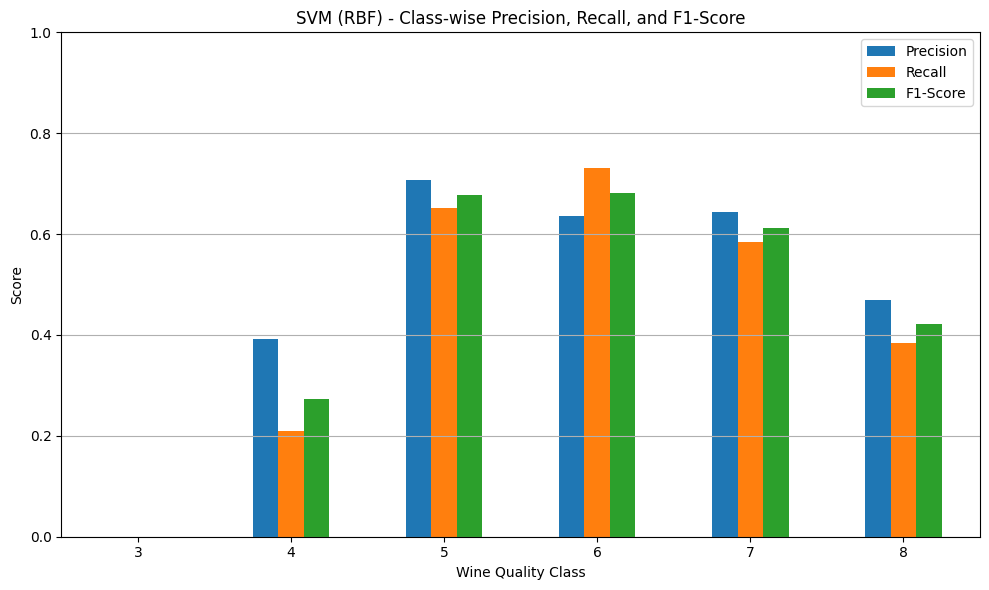

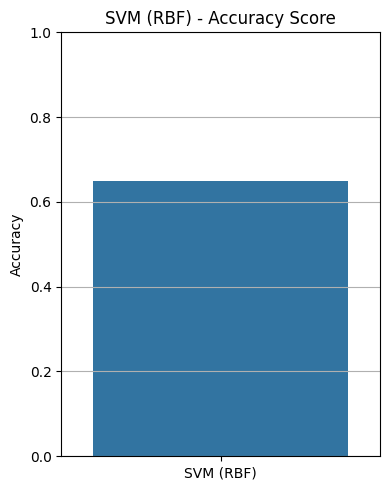

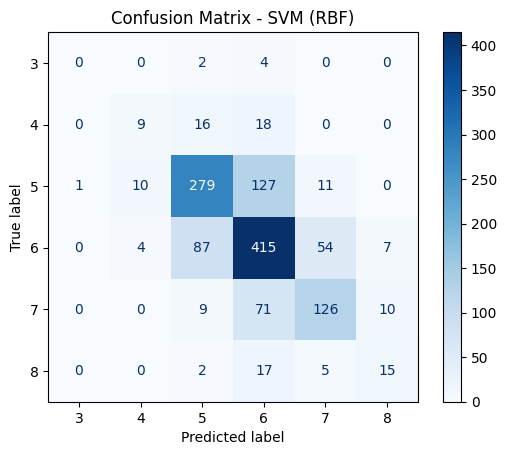

In [ ]:
'''sdfs'''
#little better than ayush model.
from sklearn.svm import SVC

svm_rbf_ = SVC(kernel='rbf', class_weight={3: 0.5, 4: 0.5, 5: 1, 6: 1, 7: 1, 8: 2}, random_state=42)        #1. can change class weights and see   #'balanced'=0.64

# param_grid = {
#     'C': [0.1, 1, 10],          # Lower C = wider margin, higher regularization
#     'gamma': [0.01, 0.1, 1]     # Smaller gamma = smoother decision boundary
# }

param_grid = {
    'C': [10],          # Lower C = wider margin, higher regularization
    'gamma': [1]     # Smaller gamma = smoother decision boundary
}

# Use your evaluate_model function like this:
metrics_df, acc, cm = evaluate_model(
    model=svm_rbf_,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name='SVM (RBF)',
    use_smote=True,
    smote_strategy={3: 1500, 4: 1500, 7: 1500, 8: 1500},           #0.65    #2.  might want to check with other SMOTE strategy and C, gamma parameters.
    # smote_strategy = 'auto',                                         #0.64
    grid_search=True,
    param_grid=param_grid,
    # feature_selection = True,
    # features_selected = [10, 7, 1, 6, 9, 4], #, 5, 3],
    search_type='grid',
    n_jobs=1,
    labels=np.arange(3, 9)
)
#[10, 7, 1, 6, 9, 4, 5, 3]



In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# rf_model = RandomForestClassifier(
#     n_estimators=80, class_weight='balanced', random_state=42
# )

# evaluate_model(
#     rf_model, X_train, y_train, X_test, y_test,
#     model_name='Random Forest',
#     labels=np.arange(3, 9)
# )


In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# param_grid = {
#     'n_estimators': [80, 100, 200],        #change this and try
#     'max_depth': [10, 20, 30, None],       #change this and try
#     'min_samples_split': [2, 5, 10],       #change this and try
# }

# rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# evaluate_model(
#     rf_model, X_train, y_train, X_test, y_test,
#     model_name='Random Forest',
#     use_smote=True,
#     smote_strategy={3: 200, 4: 200, 8: 600, 7: 900},
#     grid_search=True,
#     param_grid=param_grid,
#     search_type='grid',
#     labels=np.arange(3, 9)
# )


In [ ]:
import pandas as pd

# Load the dataset
file_path = "combined_wine_dataset.xlsx"
wine_data = pd.read_excel(file_path)

# Display basic info and first few rows
wine_data.info(), wine_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 2 columns):
 #   Column                                                                                                                                                                   Non-Null Count  Dtype 
---  ------                                                                                                                                                                   --------------  ----- 
 0   fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"  6497 non-null   object
 1   Wine_Type                                                                                                                                                                6497 non-null   object
dtypes: object(2)
memory usage: 101.6+ KB


(None,
   fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"  \
 0   7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5                                                                                                                        
 1   7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5                                                                                                                        
 2  7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;...                                                                                                                        
 3  11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58...                                                                                                                        
 4   7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5                                                                      

In [ ]:
# Split the single string column into multiple columns using ';' delimiter
split_columns = wine_data.iloc[:, 0].str.split(";", expand=True)

# Load header from the first row of the file to name the columns
header = [
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides",
    "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates",
    "alcohol", "quality"
]

# Assign correct headers to split columns and combine with 'Wine_Type'
split_columns.columns = header
wine_data_cleaned = pd.concat([split_columns, wine_data['Wine_Type']], axis=1)

# Convert appropriate columns to numeric
for col in header:
    wine_data_cleaned[col] = pd.to_numeric(wine_data_cleaned[col], errors='coerce')

# Check for missing values
wine_data_cleaned.info(), wine_data_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  Wine_Type             6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


(None,
    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0            7.4              0.70         0.00             1.9      0.076   
 1            7.8              0.88         0.00             2.6      0.098   
 2            7.8              0.76         0.04             2.3      0.092   
 3           11.2              0.28         0.56             1.9      0.075   
 4            7.4              0.70         0.00             1.9      0.076   
 
    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
 0                 11.0                  34.0   0.9978  3.51       0.56   
 1                 25.0                  67.0   0.9968  3.20       0.68   
 2                 15.0                  54.0   0.9970  3.26       0.65   
 3                 17.0                  60.0   0.9980  3.16       0.58   
 4                 11.0                  34.0   0.9978  3.51       0.56   
 
    alcohol  quality Wine_Type  
 0      9.4        5       Red  

<ipython-input-29-1c5678dcb0f4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=quality_counts.index, y=quality_counts.values, palette="viridis")


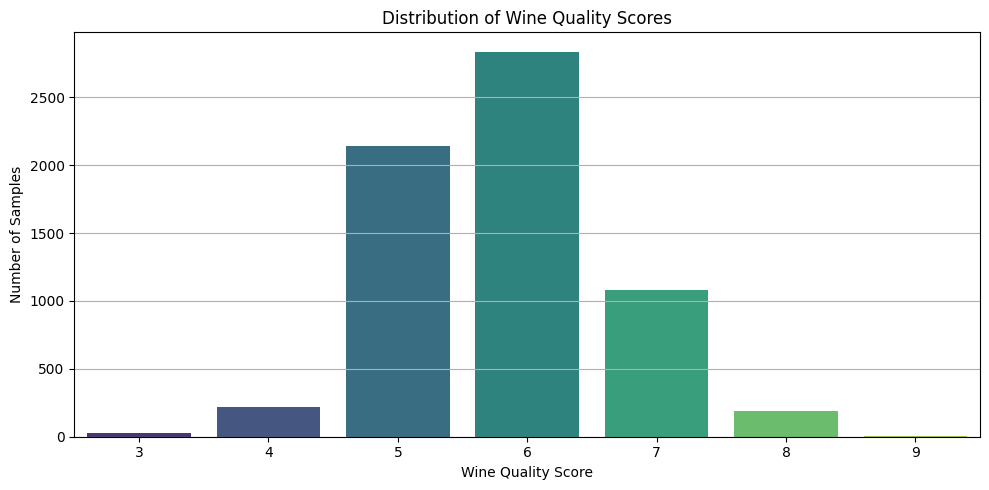

,count
quality,
3,30
4,216
5,2138
6,2836
7,1079
8,193
9,5


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each quality score
quality_counts = wine_data_cleaned['quality'].value_counts().sort_index()

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=quality_counts.index, y=quality_counts.values, palette="viridis")
plt.title("Distribution of Wine Quality Scores")
plt.xlabel("Wine Quality Score")
plt.ylabel("Number of Samples")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

quality_counts

<ipython-input-30-052adaf5af01>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="crest")


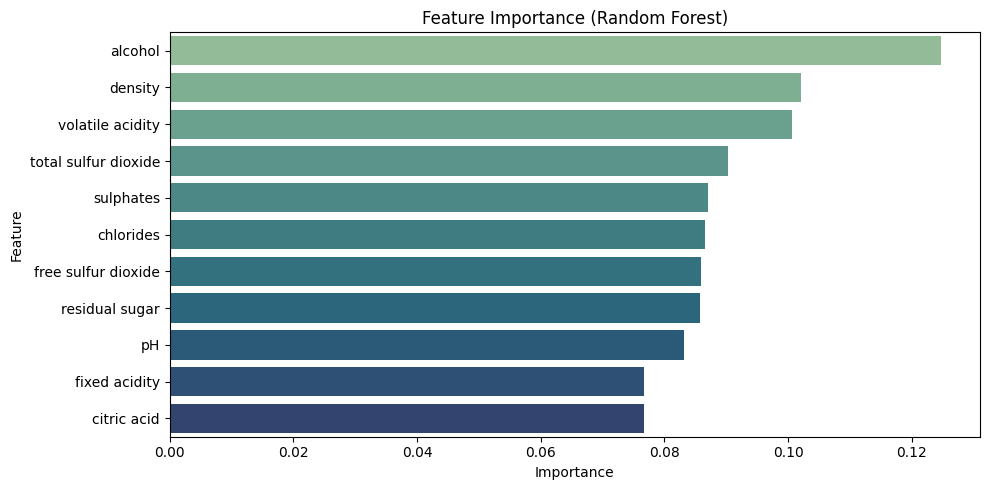

,0
alcohol,0.124794
density,0.102088
volatile acidity,0.100691
total sulfur dioxide,0.090264
sulphates,0.087102
chlorides,0.086586
free sulfur dioxide,0.085968
residual sugar,0.085781
pH,0.083164
fixed acidity,0.076783


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare features and target
X = wine_data_cleaned.drop(columns=["quality", "Wine_Type"])
y = wine_data_cleaned["quality"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Feature importance
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="crest")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

feature_importance

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Load the cleaned dataset (skip this if already loaded)
# wine_data_cleaned = pd.read_csv("your_cleaned_data.csv")

# Drop non-predictor columns
X = wine_data_cleaned.drop(columns=["quality", "Wine_Type"])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                 Feature        VIF
7                density  15.914501
3         residual sugar   7.228979
0          fixed acidity   4.896925
10               alcohol   4.782130
6   total sulfur dioxide   2.937601
8                     pH   2.536522
5    free sulfur dioxide   2.135481
1       volatile acidity   1.949413
4              chlorides   1.631958
2            citric acid   1.608220
9              sulphates   1.541526


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

# Load your cleaned DataFrame
# If loading from file, replace this line with:
# wine_data_cleaned = pd.read_excel("combined_wine_dataset.xlsx")

# Step 1: Prepare features and target
X = wine_data_cleaned.drop(columns=["quality", "Wine_Type"])
y = wine_data_cleaned["quality"]

# Step 2: Drop very rare quality classes (<10 samples)
value_counts = y.value_counts()
rare_classes = value_counts[value_counts < 10].index
mask = ~y.isin(rare_classes)
X = X[mask]
y = y[mask]

# Step 3: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Apply SMOTE with fewer neighbors
smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Step 5: Feature selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)

selector = SelectFromModel(rf, threshold="median", prefit=True)
X_selected = selector.transform(X_resampled)
selected_features = X.columns[selector.get_support()]

# Step 6: Create and save modified dataset
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)
X_selected_df["quality"] = y_resampled
X_selected_df.to_excel("modified_wine_dataset.xlsx", index=False)

print(f"✅ Modified dataset created with {len(selected_features)} selected features.")
print("Selected features:", list(selected_features))

✅ Modified dataset created with 6 selected features.
Selected features: ['fixed acidity', 'volatile acidity', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'alcohol']


In [ ]:
pip install mord

In [ ]:
import pandas as pd
import numpy as np
np.int = int
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from mord import LogisticIT  # For ordinal logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, ClassifierMixin

# Custom Ordinal SVM using multiple binary SVMs
class CustomOrdinalSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel="rbf", C=2.0):
        self.kernel = kernel
        self.C = C
        self.models = []
        self.classes_ = []

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        self.models = []
        for threshold in self.classes_[:-1]:
            binary_y = (y > threshold).astype(int)
            model = SVC(kernel=self.kernel, C=self.C, probability=True)
            model.fit(X, binary_y)
            self.models.append(model)
        return self

    def predict(self, X):
        probs = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            probs[:, i] = model.predict_proba(X)[:, 1]  # Probability of being in higher class
        # Sum how many thresholds each sample passes
        return np.sum(probs > 0.5, axis=1) + self.classes_[0]

# Load the modified dataset
data = pd.read_excel("modified_wine_dataset.xlsx")

# Separate features and target
X = data.drop(columns=["quality"])
y = data["quality"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# 1. SVM with RBF kernel
svm_rbf = SVC(kernel="rbf", C=1, gamma="scale")
svm_rbf.fit(X_train, y_train)
svm_preds = svm_rbf.predict(X_test)

print("\n🔹 SVM (RBF) Classification Report")
print(classification_report(y_test, svm_preds))

# 2. Ordinal Logistic Regression (using mord)
ordinal_logit = LogisticIT()
ordinal_logit.fit(X_train, y_train)
ord_logit_preds = ordinal_logit.predict(X_test)

print("\n🔹 Ordinal Logistic Regression Report")
print(classification_report(y_test, ord_logit_preds))

# 3. Custom Ordinal SVM (simulated using multiple binary SVMs)
custom_ord_svm = CustomOrdinalSVM(kernel="rbf", C=1.0)
custom_ord_svm.fit(X_train, y_train)
custom_preds = custom_ord_svm.predict(X_test)

print("\n🔹 Custom Ordinal SVM Report")
print(classification_report(y_test, custom_preds))


🔹 SVM (RBF) Classification Report
              precision    recall  f1-score   support

           3       0.81      0.89      0.85       567
           4       0.60      0.68      0.64       567
           5       0.54      0.54      0.54       567
           6       0.44      0.24      0.31       568
           7       0.49      0.51      0.50       568
           8       0.62      0.74      0.67       567

    accuracy                           0.60      3404
   macro avg       0.58      0.60      0.58      3404
weighted avg       0.58      0.60      0.58      3404


🔹 Ordinal Logistic Regression Report
              precision    recall  f1-score   support

           3       0.34      0.53      0.41       567
           4       0.18      0.05      0.07       567
           5       0.26      0.19      0.22       567
           6       0.26      0.30      0.28       568
           7       0.25      0.20      0.22       568
           8       0.38      0.56      0.45       567

    


🔹 SVM (RBF) Classification Report
              precision    recall  f1-score   support

           3       0.81      0.89      0.85       567
           4       0.60      0.68      0.64       567
           5       0.54      0.54      0.54       567
           6       0.44      0.24      0.31       568
           7       0.49      0.51      0.50       568
           8       0.62      0.74      0.67       567

    accuracy                           0.60      3404
   macro avg       0.58      0.60      0.58      3404
weighted avg       0.58      0.60      0.58      3404


🔹 Ordinal Logistic Regression Report
              precision    recall  f1-score   support

           3       0.34      0.53      0.41       567
           4       0.18      0.05      0.07       567
           5       0.26      0.19      0.22       567
           6       0.26      0.30      0.28       568
           7       0.25      0.20      0.22       568
           8       0.38      0.56      0.45       567

    

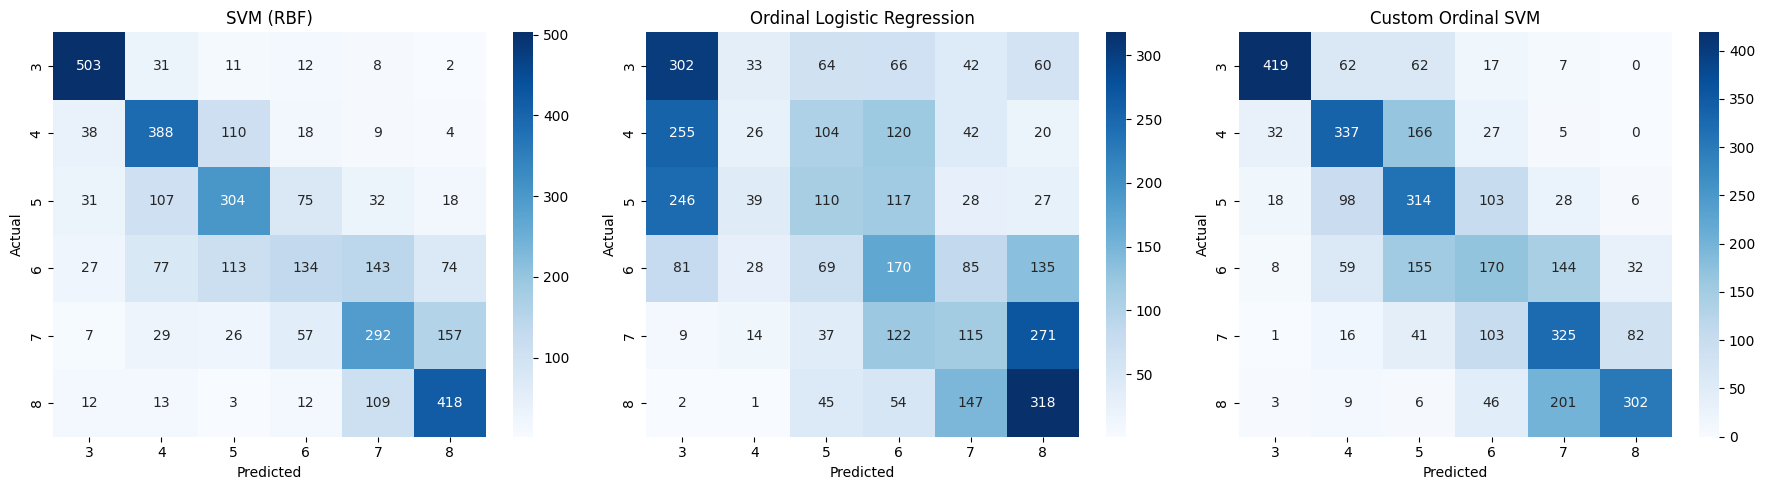

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from mord import LogisticIT

# ---- Custom Ordinal SVM Class ---- #
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomOrdinalSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel="rbf", C=1.0):
        self.kernel = kernel
        self.C = C
        self.models = []
        self.classes_ = []

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        self.models = []
        for threshold in self.classes_[:-1]:
            binary_y = (y > threshold).astype(int)
            model = SVC(kernel=self.kernel, C=self.C, probability=True)
            model.fit(X, binary_y)
            self.models.append(model)
        return self

    def predict(self, X):
        probs = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            probs[:, i] = model.predict_proba(X)[:, 1]
        return np.sum(probs > 0.5, axis=1) + self.classes_[0]

# ---- Load and prepare data ---- #
data = pd.read_excel("modified_wine_dataset.xlsx")

X = data.drop(columns=["quality"])
y = data["quality"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# ---- Model 1: SVM with RBF ---- #
svm_rbf = SVC(kernel="rbf", C=1, gamma="scale")
svm_rbf.fit(X_train, y_train)
svm_preds = svm_rbf.predict(X_test)

# ---- Model 2: Ordinal Logistic Regression (mord) ---- #
ordinal_logit = LogisticIT()
ordinal_logit.fit(X_train, y_train)
ord_logit_preds = ordinal_logit.predict(X_test)

# ---- Model 3: Custom Ordinal SVM ---- #
custom_ord_svm = CustomOrdinalSVM(kernel="rbf", C=1.0)
custom_ord_svm.fit(X_train, y_train)
custom_preds = custom_ord_svm.predict(X_test)

# ---- Print classification reports ---- #
print("\n🔹 SVM (RBF) Classification Report")
print(classification_report(y_test, svm_preds))

print("\n🔹 Ordinal Logistic Regression Report")
print(classification_report(y_test, ord_logit_preds))

print("\n🔹 Custom Ordinal SVM Report")
print(classification_report(y_test, custom_preds))

# ---- Plot confusion matrices ---- #
models = {
    "SVM (RBF)": svm_preds,
    "Ordinal Logistic Regression": ord_logit_preds,
    "Custom Ordinal SVM": custom_preds,
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, preds) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, preds, labels=np.sort(y.unique()))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=np.sort(y.unique()), yticklabels=np.sort(y.unique()))
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

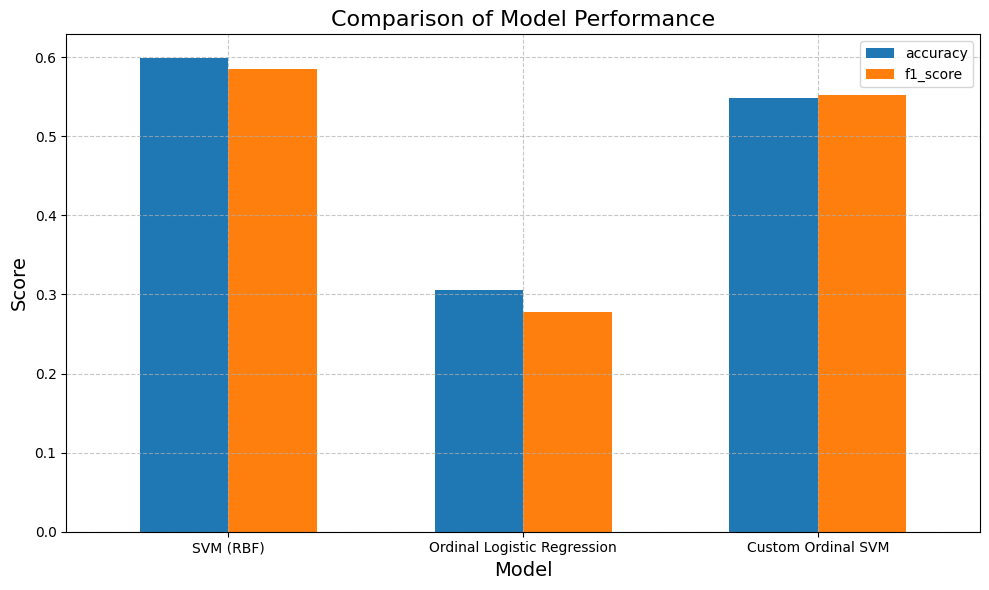

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.svm import SVC
from mord import LogisticIT

# ---- Custom Ordinal SVM Class ---- #
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomOrdinalSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel="rbf", C=1.0):
        self.kernel = kernel
        self.C = C
        self.models = []
        self.classes_ = []

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        self.models = []
        for threshold in self.classes_[:-1]:
            binary_y = (y > threshold).astype(int)
            model = SVC(kernel=self.kernel, C=self.C, probability=True)
            model.fit(X, binary_y)
            self.models.append(model)
        return self

    def predict(self, X):
        probs = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            probs[:, i] = model.predict_proba(X)[:, 1]
        return np.sum(probs > 0.5, axis=1) + self.classes_[0]

# ---- Load and prepare data ---- #
data = pd.read_excel("modified_wine_dataset.xlsx")

X = data.drop(columns=["quality"])
y = data["quality"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# ---- Model 1: SVM with RBF ---- #
svm_rbf = SVC(kernel="rbf", C=1, gamma="scale")
svm_rbf.fit(X_train, y_train)
svm_preds = svm_rbf.predict(X_test)

# ---- Model 2: Ordinal Logistic Regression (mord) ---- #
ordinal_logit = LogisticIT()
ordinal_logit.fit(X_train, y_train)
ord_logit_preds = ordinal_logit.predict(X_test)

# ---- Model 3: Custom Ordinal SVM ---- #
custom_ord_svm = CustomOrdinalSVM(kernel="rbf", C=1.0)
custom_ord_svm.fit(X_train, y_train)
custom_preds = custom_ord_svm.predict(X_test)

# ---- Compute Accuracy and F1-Score ---- #
metrics = {
    "SVM (RBF)": {
        "accuracy": accuracy_score(y_test, svm_preds),
        "f1_score": f1_score(y_test, svm_preds, average="weighted")
    },
    "Ordinal Logistic Regression": {
        "accuracy": accuracy_score(y_test, ord_logit_preds),
        "f1_score": f1_score(y_test, ord_logit_preds, average="weighted")
    },
    "Custom Ordinal SVM": {
        "accuracy": accuracy_score(y_test, custom_preds),
        "f1_score": f1_score(y_test, custom_preds, average="weighted")
    }
}

# ---- Bar Graph Plot ---- #
metrics_df = pd.DataFrame(metrics).T

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting accuracy and f1_score for each model
metrics_df.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'], width=0.6)

# Labels and title
ax.set_title('Comparison of Model Performance', fontsize=16)
ax.set_ylabel('Score', fontsize=14)
ax.set_xlabel('Model', fontsize=14)

# Customize x-ticks
ax.set_xticklabels(metrics_df.index, rotation=0)

# Add a grid
ax.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
